##### License: Attribution 4.0 International (CC BY 4.0)

#### [https://creativecommons.org/licenses/by/4.0/](https://creativecommons.org/licenses/by/4.0/)

# CompBayes Report 4
### By Andrea Jackson

In [1]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np

from thinkbayes2 import *
import thinkplot

import pandas as pd
from itertools import product

### Chapter 7 Exercise

**Exercise**: In the final match of the 2014 FIFA World Cup, Germany defeated Argentina 1-0. What is the probability that Germany had the better team? What is the probability that Germany would win a rematch?

For a prior distribution on the goal-scoring rate for each team, use a gamma distribution with parameter 1.3.

#### What is the probability that Germany had a better team?

In [2]:
#From Allen Downey's thinkbayes2.py file
from scipy.special import gamma
def EvalGammaPdf(lam, a):
    """Computes the Gamma PDF.
    lam: where to evaluate the PDF
    a: parameter of the gamma distribution
    returns: float probability
    """
    return lam**(a-1) * math.exp(-lam) / gamma(a)

def MakeGammaPmf(lams, a):
    """Makes a PMF discrete approx to a Gamma distribution.
    lam: parameter lambda in events per unit time
    xs: upper bound of the Pmf
    returns: normalized Pmf
    """
    pmf = Pmf()
    for lam in lams:
        pmf[lam] = EvalGammaPdf(lam, a)
        
    pmf.Normalize()
    return pmf

In [3]:
class Soccer(Suite):

    def __init__(self, label=None):
        """Initializes the Soccer object.
        """
        xs = np.linspace(0, 8, 101)
        lam = 1.3

        pmf = MakeGammaPmf(xs,lam)
        Suite.__init__(self, pmf, label=label)
            
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        Evaluates the Gamma Pmf for lambda and k.

        hypo: goal scoring rate in goals per game
        data: goals scored in one soccer game
        """
        lam = hypo
        k = data
        like = EvalGammaPdf(k, lam)
        return like

In [4]:
germ_suite = Soccer('Germany')
arg_suite = Soccer('Argentina')

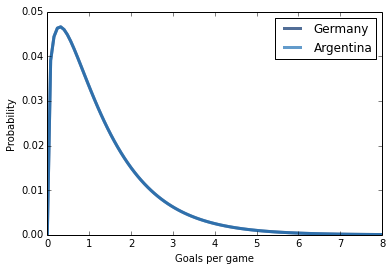

In [5]:
thinkplot.PrePlot(num=2)
thinkplot.Pdf(germ_suite)
thinkplot.Pdf(arg_suite)
thinkplot.Config(xlabel='Goals per game',
                ylabel='Probability')

In [6]:
germ_suite.Mean()

1.3103599490022564

In [7]:
germ_suite.UpdateSet([1])

0.25975909549587689

In [8]:
germ_suite.Mean()

1.3167374583298173

In [9]:
#ProbGreater function is from Allen Downney's Chapter 5 notebook
def ProbGreater(pmf1, pmf2):
    total = 0
    for x1, prob1 in pmf1.Items():
        for x2, prob2 in pmf2.Items():   
            if x1 > x2:
                total += prob1 * prob2
    return total

In [10]:
ProbGreater(germ_suite, arg_suite)

0.54393398431737339

There is a 0.5439 probability Germany had a better soccer team than Argentina.

#### What is the probability that Germany would win a rematch?

I am unsure how to solve this question.

### Chapter 9 Exercise

**Exercise:** The GPS problem.  According to [Wikipedia]()

￼
> GPS included a (currently disabled) feature called Selective Availability (SA) that adds intentional, time varying errors of up to 100 meters (328 ft) to the publicly available navigation signals. This was intended to deny an enemy the use of civilian GPS receivers for precision weapon guidance.
> [...]
> Before it was turned off on May 2, 2000, typical SA errors were about 50 m (164 ft) horizontally and about 100 m (328 ft) vertically.[10] Because SA affects every GPS receiver in a given area almost equally, a fixed station with an accurately known position can measure the SA error values and transmit them to the local GPS receivers so they may correct their position fixes. This is called Differential GPS or DGPS. DGPS also corrects for several other important sources of GPS errors, particularly ionospheric delay, so it continues to be widely used even though SA has been turned off. The ineffectiveness of SA in the face of widely available DGPS was a common argument for turning off SA, and this was finally done by order of President Clinton in 2000.

Suppose it is 1 May 2000, and you are standing in a field that is 200m square.  You are holding a GPS unit that indicates that your location is 51m north and 15m west of a known reference point in the middle of the field.

However, you know that each of these coordinates has been perturbed by a "feature" that adds random errors with mean 0 and standard deviation 30m.

1) After taking one measurement, what should you believe about your position?

Note: Since the intentional errors are independent, you could solve this problem independently for X and Y.  But we'll treat it as a two-dimensional problem, partly for practice and partly to see how we could extend the solution to handle dependent errors.

You can start with the code in gps.py.

2) Suppose that after one second the GPS updates your position and reports coordinates (48, 90).  What should you believe now?

3) Suppose you take 8 more measurements and get:

    (11.903060613102866, 19.79168669735705)
    (77.10743601503178, 39.87062906535289)
    (80.16596823095534, -12.797927542984425)
    (67.38157493119053, 83.52841028148538)
    (89.43965206875271, 20.52141889230797)
    (58.794021026248245, 30.23054016065644)
    (2.5844401241265302, 51.012041625783766)
    (45.58108994142448, 3.5718287379754585)

At this point, how certain are you about your location?

In [11]:
class Gps(Suite, Joint):
    """Represents hypotheses about your location in the field."""

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: alpha,beta 
        data: sequence of locations
        """
        hypo_x,hypo_y = hypo
        x,y = data
        
        std_dev = 30
        
        x_like = stats.norm.pdf(hypo_x,x,std_dev)
        y_like = stats.norm.pdf(hypo_y,y,std_dev)
        
        like = x_like*y_like
        
        return like

In [12]:
coords = np.linspace(-100, 150, 101)
joint = Gps(product(coords, coords))

joint.Update((51, -15))

1.5646636550871518e-05

50.955144685228973

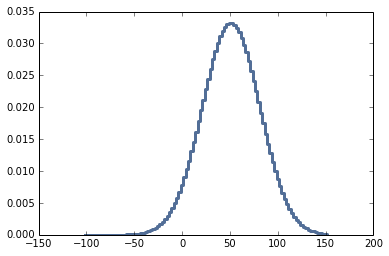

In [13]:
horizontalPmf = joint.Marginal(0)
thinkplot.Pmf(horizontalPmf)
horizontalPmf.Mean()

-14.808075522124236

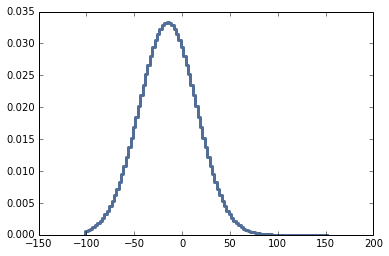

In [14]:
verticalPmf = joint.Marginal(1)
thinkplot.Pmf(verticalPmf)
verticalPmf.Mean()

#### 1) After taking one measurement (51,-15), I do not believe that my position is very accurate because the standard deviation of my horizontal and vertical positions' pmf are large.

In [15]:
joint.Update((48,90))

4.1351466554594196e-06

49.499915642077291

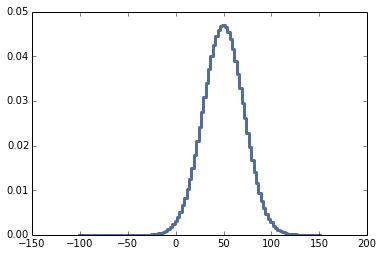

In [16]:
horizontalPmf2 = joint.Marginal(0)
thinkplot.Pmf(horizontalPmf2)
horizontalPmf2.Mean()

37.499995252912186

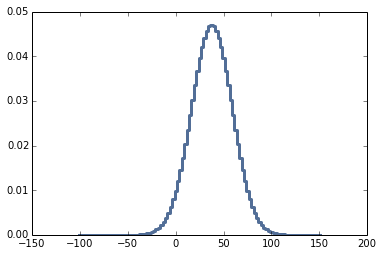

In [17]:
verticalPmf2 = joint.Marginal(1)
thinkplot.Pmf(verticalPmf2)
verticalPmf2.Mean()

#### 2) After the GPS updates my position and reports coordinates (48,90), I should believe my position is more accurate because the standard deviation of the horizontal and vertical positions' pmfs has decreased. 

In [18]:
pairs = [(11.903060613102866, 19.79168669735705),
        (77.10743601503178, 39.87062906535289),
        (80.16596823095534, -12.797927542984425),
        (67.38157493119053, 83.52841028148538),
        (89.43965206875271, 20.52141889230797),
        (58.794021026248245, 30.23054016065644),
        (2.5844401241265302, 51.012041625783766),
        (45.58108994142448, 3.5718287379754585)]

joint.UpdateSet(pairs)

1.1018742778779622e-34

53.195724295083402

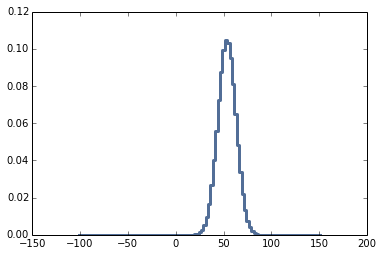

In [19]:
horizontalPmf3 = joint.Marginal(0)
thinkplot.Pmf(horizontalPmf3)
horizontalPmf3.Mean()

31.072862791793543

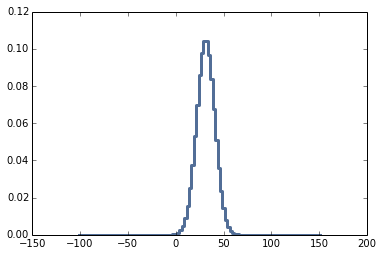

In [20]:
verticalPmf3 = joint.Marginal(1)
thinkplot.Pmf(verticalPmf3)
verticalPmf3.Mean()

In [21]:
horizontal_std = horizontalPmf3.Std()
vertical_std = verticalPmf3.Std()

In [22]:
"Horizontal standard deviation: ", horizontal_std

('Horizontal standard deviation: ', 9.486832980505152)

In [23]:
"Vertical standard deviation: ", vertical_std

('Vertical standard deviation: ', 9.48683298050515)

#### 3) After the GPS updates my position with 8 more coordinates, I should believe my position is very accurate. The standard deviations of the horizontal and vertical marginal distributions are much more narrower, meaning the GPS position is more accurate. 

### Original Bayes Problem Type III (multiple dimensions)

Geocaching is an outdoor, recreational activity where participants use GPS devices to hide and seek containers called "geocaches"-[Wikipedia](https://www.wikiwand.com/en/Geocaching)

A student decides to go geocaching. However, the student is a novice and doesn't know their neighborhood very well. As a result, they have a difficult time finding their first geocache. 

After an hour of searching for a geocache, the student finally finds it.

The following dataframe contains the student's GPS location as they try to find the geocache. 